In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# Gym-like Maze Environment
class MiniMazeEnv:
    """
    Mini maze environment with dynamic size and 4 discrete actions.
    Actions are: 0: Left, 1: Down, 2: Right, 3: Up
    Starts at the bottom left corner and the top right corner 
    gives a reward of 1 and is a terminal state.
    """
    def __init__(self, size=5):
        self.size = size
        self.state_space_n = size * size
        self.action_space_n = 4
        
        # Start at bottom left
        self.start_state = 0
        self.goal_state = self.state_space_n - 1
        self.state = self.start_state
        
        self.rewards = np.zeros(self.state_space_n)
        # Top right corner reward
        self.rewards[self.goal_state] = 1
        
        # Dictionary where the keys are each state in maze and the values are 
        # another dictionary where those keys are the actions and the values are the 
        # next states. 
        self.transitions = {
            s: {
                a: self._get_next_state(s, a) for a in range(self.action_space_n)
                } for s in range(self.state_space_n)
            }
        self.terminal_states = [self.goal_state]

    def _get_next_state(self, state, action):
        row, col = divmod(state, self.size)
        # Counter clockwise orientation
        if action == 0:  # Left
            col = max(col - 1, 0)
        elif action == 1:  # Down
            row = max(row - 1, 0)
        elif action == 2:  # Right
            col = min(col + 1, self.size - 1)
        elif action == 3:  # Up
            row = min(row + 1, self.size - 1)

        return row * self.size + col

    def reset(self):
        self.state = self.start_state
        return self.state

    def step(self, action):
        if self.state in self.terminal_states:
            return self.state, self.rewards[self.state], True, {}
        next_state = self.transitions[self.state][action]
        reward = self.rewards[next_state]
        self.state = next_state
        done = self.state in self.terminal_states
        return next_state, reward, done, {}

    def render(self):
        grid = np.full((self.size, self.size), '.')
        row, col = divmod(self.state, self.size)
        # Agent position
        grid[self.size - 1 - row, col] = 'A'
        # Reward position
        grid[0, self.size - 1] = 'R' if self.state != self.goal_state else 'A'
        print("\n".join(" ".join(row) for row in grid))
        print('\n')
        
    def action_space_sample(self):
        return np.random.choice(self.action_space_n)


# env = MiniMazeEnv(size=3)
# state = env.reset()
# env.render()
# env.step(2)
# env.render()


In [6]:
import numpy as np

def visualize_policy(Q_table, shape):
    action_symbols = ['←', '↓', '→', '↑']

    policy = np.argmax(Q_table, axis=1)

    grid = [['' for _ in range(shape[1])] for _ in range(shape[0])]

    for state in range(shape[0] * shape[1]):
        row, col = divmod(state, shape[1])
        row = shape[0] - 1 - row
        if state == 0:
            grid[row][col] = 'S'
        elif state == shape[0] * shape[1] - 1:
            grid[row][col] = 'G'
        else:
            grid[row][col] = action_symbols[policy[state]]

    return grid

# np.random.seed(0)
# dummy_Q_table = np.random.random((9, 4))

# # Visualize the policy
# maze_policy = visualize_policy(dummy_Q_table, (3, 3))
# for row in maze_policy:
#     print(' '.join(row))


In [182]:
# Qlearning - Off-Policy
class QLearning():
    def __init__(self, env, epsilon, lr, gamma, epsilon_decay=False):
        self.env = env
        # self.Q_table = np.zeros((env.state_space_n, env.action_space_n))
        self.Q_table = np.random.rand(env.state_space_n, env.action_space_n)
        
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = 0
        self.epsilon_decay_rate = 0.001
        self.epsilon = epsilon

        self.lr = lr
        self.gamma = gamma
        
        
        
    def policy(self, state, steps):
        # epsilon greedy
        if self.epsilon_decay:
            self.epsilon = max(self.epsilon_min, self.epsilon - (self.epsilon_decay_rate * steps))
            
        if np.random.uniform(0, 1) < self.epsilon:
            return self.env.action_space_sample()
        else:
            return np.argmax(self.Q_table[state, :])
        
    def update(self, old_state, old_action, new_state, reward):
        prediction = self.Q_table[old_state, old_action]
        target = reward + self.gamma * np.max(self.Q_table[new_state, :])
        self.Q_table[old_state, old_action] = prediction + self.lr * (target - prediction)

In [19]:
def plot(total_rewards_per_episode):
    plt.figure(figsize=(12, 8))
    plt.plot(total_rewards_per_episode, label='Steps')
    # for c in c_values:
    #     plt.plot(total_regret_ucb[c], label=f'UCB c={c}')
    plt.xlabel('Episodes')
    plt.ylabel('Total Steps')
    plt.title('Total Steps over Episodes')
    plt.legend()
    plt.show()

In [42]:
# Setup
env = MiniMazeEnv(size=5)

# Hyperparameters
episodes = 5000
epsilon = 0.1
lr = 0.01
gamma = 0.8


In [161]:
def train(eps, epsilon, lr, gamma, epsilon_decay=False):
    agent_qlearning = QLearning(env, epsilon, lr, gamma, epsilon_decay=epsilon_decay)
    # print('Policy Before Training')
    # maze_policy = visualize_policy(agent_qlearning.Q_table, (5, 5))
    # for row in maze_policy:
    #     print(' '.join(row))
        
    total_steps_per_episode = []
    
    # Training Loop
    for i in range(eps):
        state = env.reset()
        
        done = False
        steps = 0
        while not done:
            action = agent_qlearning.policy(state, steps)
            
            new_state, reward, done, info = env.step(action)

            agent_qlearning.update(state, action, new_state, reward)
            
            state = new_state
            steps += 1
        
        total_steps_per_episode.append(steps)
    
    # Policy After Training
    print('Policy After Training')
    maze_policy = visualize_policy(agent_qlearning.Q_table, (5, 5))
    for row in maze_policy:
        print(' '.join(row))
        
    return total_steps_per_episode

Policy After Training
← ↑ ← → G
→ ↑ → → ↑
↓ ↑ ← ← ↑
→ ← → ↓ →
S ↑ ↑ → →
Policy After Training
→ ↓ → → G
← ← ↓ ↑ ↑
→ ↑ ← ← ↑
↑ ↑ → ↑ ↑
S ← ↑ ↑ ↓
Policy After Training
→ → → → G
← → ↑ → ↑
← ↑ → → ↑
↑ → ↑ → ↑
S → ↑ → ↑
Policy After Training
→ → → → G
↑ → ↑ ↑ ↑
↑ → ↑ ↑ ↑
↑ → → ↑ ↑
S → → → ↑
Policy After Training
→ → → → G
→ → → ↑ ↑
↑ ↑ ↑ → ↑
↑ ↑ → ↑ ↑
S ↑ → → ↑
Policy After Training
→ → → → G
→ ↑ ↑ → ↑
→ ↑ → → ↑
↑ → ↑ ↑ ↑
S → ↑ → ↑


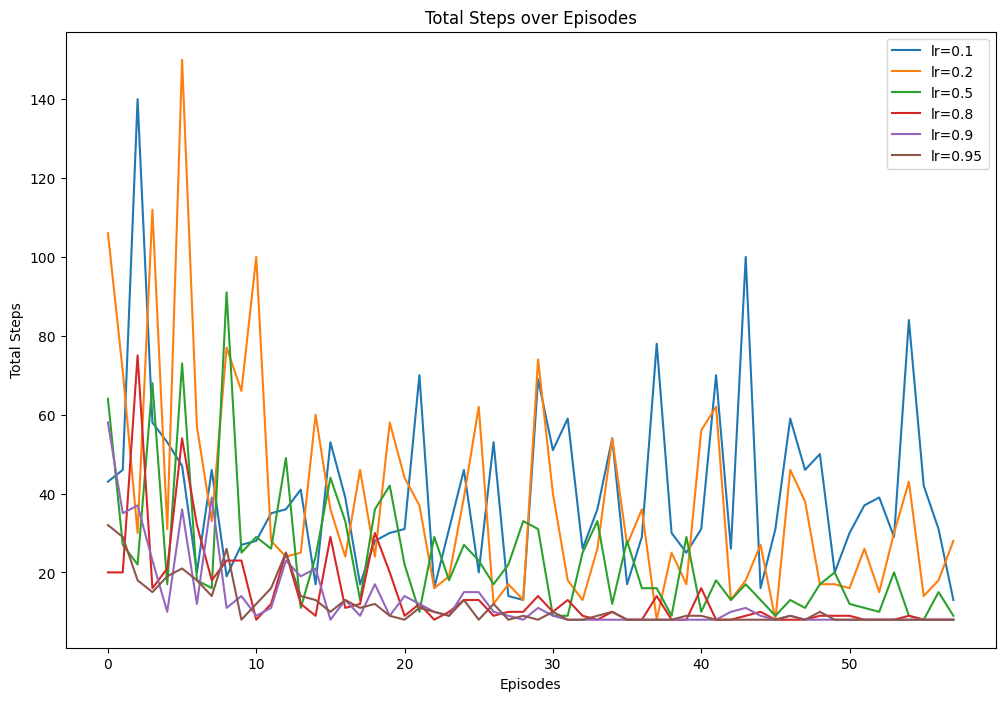

In [176]:
lr_values = [0.1, 0.2, 0.5, 0.8, 0.9, 0.95]

plt.figure(figsize=(12, 8))
for lr in lr_values:
    run = train(100, 1, lr, 0.05, epsilon_decay=True)[2:60]
    plt.plot(run, label=f'lr={lr}')

plt.xlabel('Episodes')
plt.ylabel('Total Steps')
plt.title('Total Steps over Episodes')
plt.legend()
plt.show()

Policy After Training
→ → → → G
↑ ↑ ↑ → ↑
→ ↑ ↑ ↑ ↑
↑ → → → ↑
S ↑ → → ↑
Policy After Training
→ → → → G
→ → → → ↑
↑ → ↑ ↑ ↑
↑ ↑ → ↑ ↑
S → ↑ → ↑
Policy After Training
→ → → → G
↑ → → ↑ ↑
↑ → ↑ ↑ ↑
↑ → → ↑ ↑
S → ↑ ↑ ↑
Policy After Training
→ → → → G
→ → ↑ → ↑
→ ↑ ↑ ↑ ↑
↑ ↑ ↑ ↑ ↑
S ↑ ↑ ↑ ↑
Policy After Training
→ → → → G
↑ ↑ ↑ → ↑
→ ↑ ↑ ↑ ↑
→ → ↑ → ↑
S ↑ → ↑ ↑
Policy After Training
→ → → → G
→ → → ↑ ↑
→ ↑ → ↑ ↑
→ → ↑ → ↑
S → → → ↑


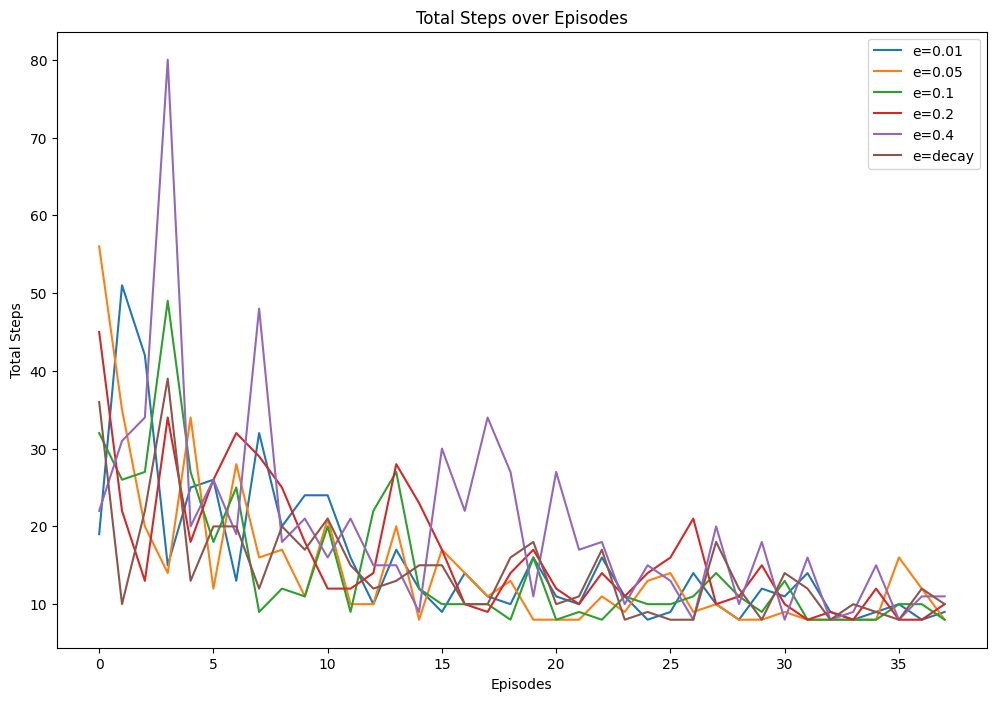

In [165]:
epsilon_values = [0.01, 0.05, 0.1,0.2,0.4]

plt.figure(figsize=(12, 8))
for e in epsilon_values:
    run = train(100, e, 0.9, 0.1)[2:40]
    plt.plot(run, label=f'e={e}')

run = train(100, 1, 0.9, 0.1, epsilon_decay=True)[2:40]
plt.plot(run, label=f'e=decay')

plt.xlabel('Episodes')
plt.ylabel('Total Steps')
plt.title('Total Steps over Episodes')
plt.legend()
plt.show()

Policy After Training
→ → → → G
↑ ↑ → ↑ ↑
→ ↑ → → ↑
↑ ↑ → ↑ ↑
S → → → ↑
Policy After Training
→ → → → G
↑ → → → ↑
↑ → ↑ → ↑
→ ↑ ↑ ↑ ↑
S → → → ↑
Policy After Training
→ → → → G
↑ → → ↑ ↑
→ ↑ → → ↑
↑ ↑ ↑ ↑ ↑
S → ↑ ↑ ↑
Policy After Training
↑ ↑ ↑ → G
↑ → ↑ → ↑
→ → → ↑ ↑
→ → → ↑ ↑
S → ↑ ↑ ↑
Policy After Training
↑ ↑ → ↑ G
→ → → → ↑
→ ↑ → ↑ ↑
↑ → → ↑ ↑
S → → ↑ ↑
Policy After Training
↓ → → → G
↑ ↓ → → ↑
← → ↑ → →
↑ ↑ → ↑ ←
S ↑ ↑ ← ←
Policy After Training
↓ ← ↓ ↓ G
↓ → ↓ ← ↑
↑ → → → ↑
→ ↑ ↑ ↑ →
S ↓ ↑ ↓ ←
Policy After Training
↑ ↓ ← → G
→ → → ↑ →
→ → ↑ ↓ ↓
↑ ↑ ← ← ↑
S ↑ ← ↑ →


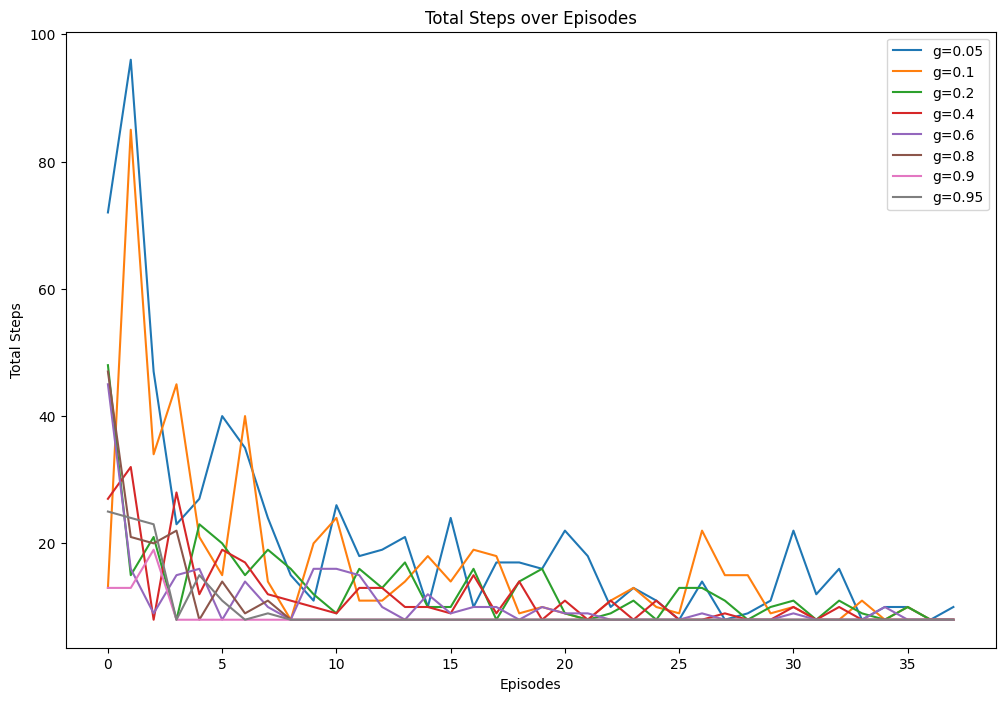

In [168]:
gamma_values = [0.05, 0.1, 0.2, 0.4, 0.6, 0.8, 0.9, 0.95]

plt.figure(figsize=(12, 8))
for g in gamma_values:
    run = train(100, 1, 0.8, g, epsilon_decay=True)[2:40]
    plt.plot(run, label=f'g={g}')

plt.xlabel('Episodes')
plt.ylabel('Total Steps')
plt.title('Total Steps over Episodes')
plt.legend()
plt.show()

Policy After Training
→ → → → G
→ ↑ → ↑ ↑
→ → → → ↑
↑ → → → ↑
S ↑ → ↑ ↑


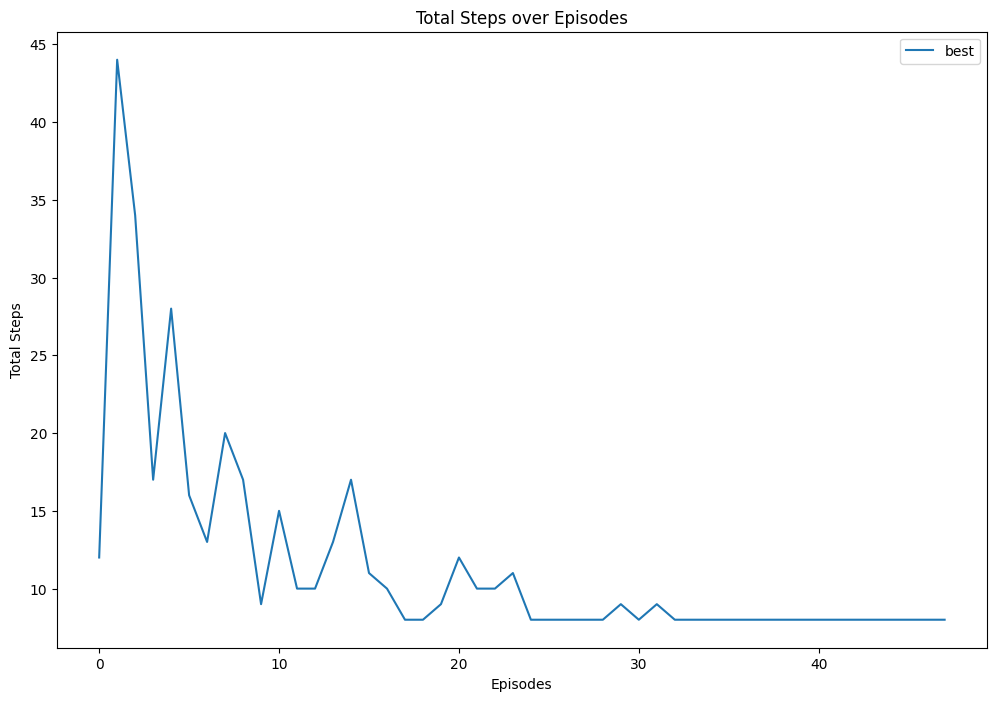

In [181]:
plt.figure(figsize=(12, 8))

run = train(100, 1, 0.95, 0.05, epsilon_decay=True)[2:50]
plt.plot(run, label=f'best')

plt.xlabel('Episodes')
plt.ylabel('Total Steps')
plt.title('Total Steps over Episodes')
plt.legend()
plt.show()